In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load dataset

In [2]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/test',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=False,
                                                   batch_size = 64)

Found 7000 images belonging to 20 classes.
Found 3000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


# Resnet50

In [4]:
input_layer = K.Input(shape=(160,160,3))
resnet_model = K.applications.ResNet50(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in resnet_model.layers:
    layer.trainable = False
for i, layer in enumerate(resnet_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [4]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

In [6]:
inputs = K.layers.Input(shape=(160,160,3), name="image")  

resnet50 = resnet_model(inputs)
flat = K.layers.GlobalAveragePooling2D()(resnet50)
output = K.layers.Dense(20, activation='softmax')(flat)

model = K.Model(inputs=inputs, outputs=output)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 160, 160, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                40980     
                                                                 
Total params: 23,628,692
Trainable params: 40,980
Non-trainable params: 23,587,712
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

In [7]:
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/resnet50.hdf5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(train_dataset,
                    epochs = 150,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/150
110/110 [==============================] - ETA: 0s - loss: 2.9635 - accuracy: 0.0747 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5800 - f1_score: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.13167, saving model to /content/drive/MyDrive/resnet50.hdf5
110/110 [==============================] - 34s 248ms/step - loss: 2.9635 - accuracy: 0.0747 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5800 - f1_score: 0.0000e+00 - val_loss: 2.8715 - val_accuracy: 0.1317 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6625 - val_f1_score: 0.0000e+00
Epoch 2/150
110/110 [==============================] - ETA: 0s - loss: 2.8484 - accuracy: 0.1491 - precision: 0.4000 - recall: 2.8571e-04 - auc: 0.6897 - f1_score: 5.5944e-04
Epoch 2: val_accuracy improved from 0.13167 to 0.20233, saving model to /content/drive/MyDrive/resnet50.hdf5
110/110 [==============================] - 23s 205ms/step - loss: 2.8484 - accuracy: 0.1491 - precision: 0.4000 - rec

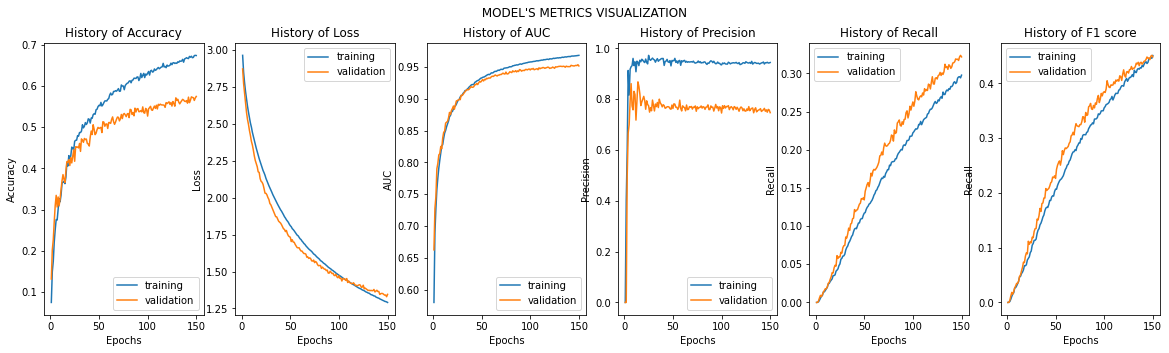

In [8]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,f1_score,val_f1_score):
    
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])

    ax6.plot(range(1, len(f1_score) + 1), f1_score)
    ax6.plot(range(1, len(val_f1_score) + 1), val_f1_score)
    ax6.set_title('History of F1 score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('Recall')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['recall'],history.history['val_recall'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [9]:
#model.save('resnet50.hdf5')
model = K.models.load_model('/content/drive/MyDrive/resnet50.hdf5', custom_objects={"f1_score": f1_score})
name_last_layer = str(model.layers[-1])
name_seclast_layer = str(model.layers[-2])

model2 = K.Sequential()
for layer in model.layers:
    if str(layer) != name_last_layer:
        if str(layer) != name_seclast_layer:
            model2.add(layer)
        
model2.summary()    

model2.save('/content/drive/MyDrive/resnet50_mod.hdf5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


# Testing

In [9]:
model = K.models.load_model("resnet50.hdf5", custom_objects={"f1_score": f1_score})
loss,accuracy,precision,recall,auc,f1_score = model.evaluate(test_dataset)
print("Testing Loss:")
print(loss)
print("Testing Accuracy:")
print(accuracy)
print("Testing Precision:")
print(precision)
print("Testing Recall:")
print(recall)
print("Testing F1-Score:")
print(f1_score)
print("Testing AUC:")
print(auc)

32/32 [==============================] - 108s 3s/step - loss: 1.6945 - accuracy: 0.5100 - precision: 0.7029 - recall: 0.3490 - auc: 0.9139 - f1_score: 0.4331
Testing Loss:
1.6944905519485474
Testing Accuracy:
0.5099999904632568
Testing Precision:
0.7029204368591309
Testing Recall:
0.3490000069141388
Testing F1-Score:
0.43314436078071594
Testing AUC:
0.9139387607574463


C:\Users\aroy8\AppData\Local\Temp/ipykernel_23060/3580747851.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1157 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix


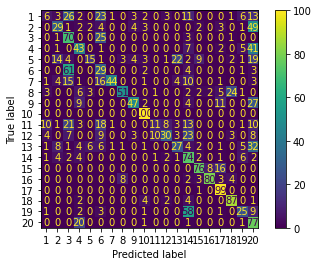

Classification Report
              precision    recall  f1-score   support

           1       0.22      0.06      0.09       100
           2       0.45      0.29      0.35       100
           3       0.34      0.70      0.45       100
           4       0.44      0.43      0.43       100
           5       0.58      0.15      0.24       100
           6       0.21      0.29      0.25       100
           7       0.94      0.44      0.60       100
           8       0.81      0.51      0.63       100
           9       0.77      0.47      0.58       100
          10       0.83      1.00      0.91       100
          11       0.48      0.11      0.18       100
          12       0.65      0.30      0.41       100
          13       0.45      0.27      0.34       100
          14       0.33      0.74      0.46       100
          15       0.78      0.76      0.77       100
          16       0.89      0.80      0.84       100
          17       0.69      0.99      0.81       100
     

In [10]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))